<a href="https://colab.research.google.com/github/cutemfc/Time_series_project/blob/main/XGboost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Import the dataset and mount google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
df_train_2014=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_train_2014.csv')
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
df_train_2014.dtypes

,0
store_nbr,int64
item_nbr,int64
date,datetime64[ns]
id,float64
unit_sales,float64
onpromotion,float64


In [ ]:
# dateframe the date and Filter the data before 2014-04-01
df_train_2014['date']=pd.to_datetime(df_train_2014['date'])
cutoff_date = pd.to_datetime('2014-04-01')
df_train = df_train_2014[df_train_2014['date'] < cutoff_date]




In [ ]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


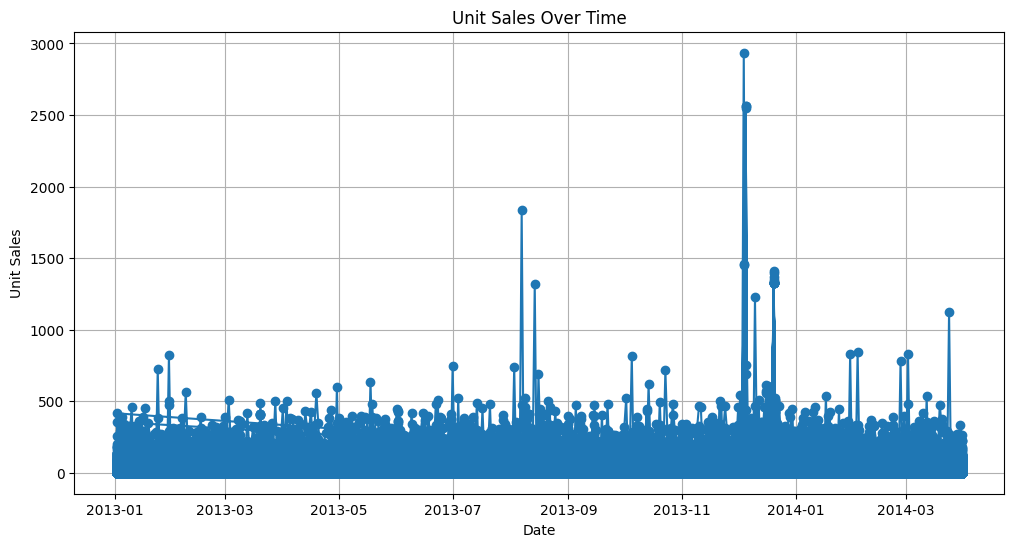

In [ ]:
# plot the sales unit and date line plot
plt.figure(figsize=(12,6))
plt.plot(df_train['date'],df_train['unit_sales'],marker='o',linestyle='-')
plt.title('Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
df_train.shape

(9437752, 6)

In [ ]:
# Groupby by 'date' and aggregate 'unit_sales' by sum

df_train = df_train.groupby('date')['unit_sales'].sum().reset_index()
df_train.head()


,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30849.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


In [ ]:
# check the missing values
df_train.isnull().sum()

,0
date,0
unit_sales,0


# Feature Eingeering
(1) Creating Lag features

(2) Creating Rolling statistics

(3) Adding Date-based Features


In [ ]:
# create lag features
df_train['lag_1'] = df_train['unit_sales'].shift(1)
df_train['lag_7'] = df_train['unit_sales'].shift(7)
df_train['lag_30'] = df_train['unit_sales'].shift(30)

# Drop any rows with NaN values after creating lag features
df_train.dropna(inplace=True)
# Set date as index
df_train.set_index('date', inplace=True)

In [ ]:
df_train.head()

,unit_sales,lag_1,lag_7,lag_30
date,,,,
2013-02-01,36573.0,28619.0,30331.0,42320.0
2013-02-02,48688.0,36573.0,37643.0,32708.0
2013-02-03,46210.0,48688.0,38829.0,30849.0
2013-02-04,31774.0,46210.0,28117.0,42351.0
2013-02-05,30152.0,31774.0,26737.0,43988.0


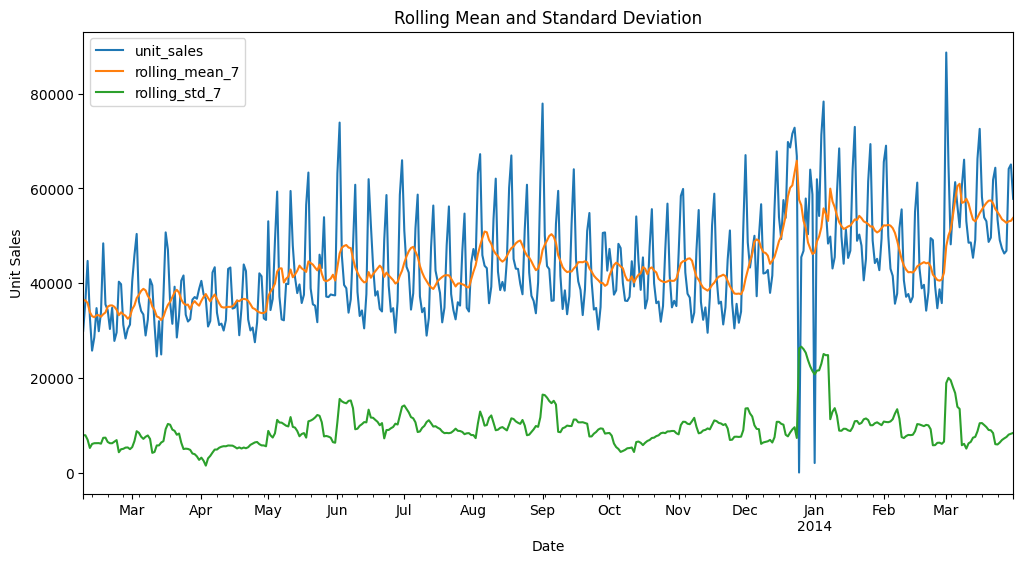

In [ ]:
# Creating Rolling Statistics
df_train['rolling_mean_7'] = df_train['unit_sales'].rolling(window=7).mean()
df_train['rolling_std_7'] = df_train['unit_sales'].rolling(window=7).std()
# Drop any NaN values afteer creating rolling features
df_train.dropna(inplace=True)

# Visualization the new featuress alongside the original sales
df_train[['unit_sales','rolling_mean_7','rolling_std_7']].plot(figsize=(12,6))
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.show()

In [ ]:
# add time based Features
df_train['year'] = df_train.index.year
df_train['month'] = df_train.index.month
df_train['day_of_week'] = df_train.index.dayofweek
df_train['is_weekend'] = df_train['day_of_week'].apply(lambda x:1 if x>=5 else 0)

In [ ]:
df_train.head()

,date,unit_sales,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7,year,month,day_of_week,is_weekend
36,2013-03-21,28521.0,39249.0,24936.0,30320.0,38595.142857,7977.605644,2013,3,3,0
37,2013-03-22,33132.0,28521.0,37314.0,34799.0,37997.714286,8241.756563,2013,3,4,0
38,2013-03-23,40533.0,33132.0,50724.0,27801.0,36541.857143,6287.447718,2013,3,5,1
39,2013-03-24,41627.0,40533.0,47087.0,29581.0,35761.857143,4959.701484,2013,3,6,1
40,2013-03-25,33326.0,41627.0,35858.0,40307.0,35400.142857,5043.149295,2013,3,0,0


In [ ]:
df_train.shape

(418, 10)

# Split the data into Training and Testing data

In [ ]:
# Define target and features
X=df_train.drop(columns=['unit_sales'],axis=1)
y=df_train['unit_sales']


In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=False) # do not interrupt the order of data

#Implementing XGBoost for Time-Series Forecasting

In [ ]:
# Initialize the XGBoost regressor
xgboost_model=xgb.XGBRegressor(objective='reg:squarederror',n_estimator=100,max_depth=5,learning_rate=0.1)

# train the XGBoost model
xgboost_model.fit(X_train,y_train)

# Make predictions on the test set
y_pred=xgboost_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:10:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)


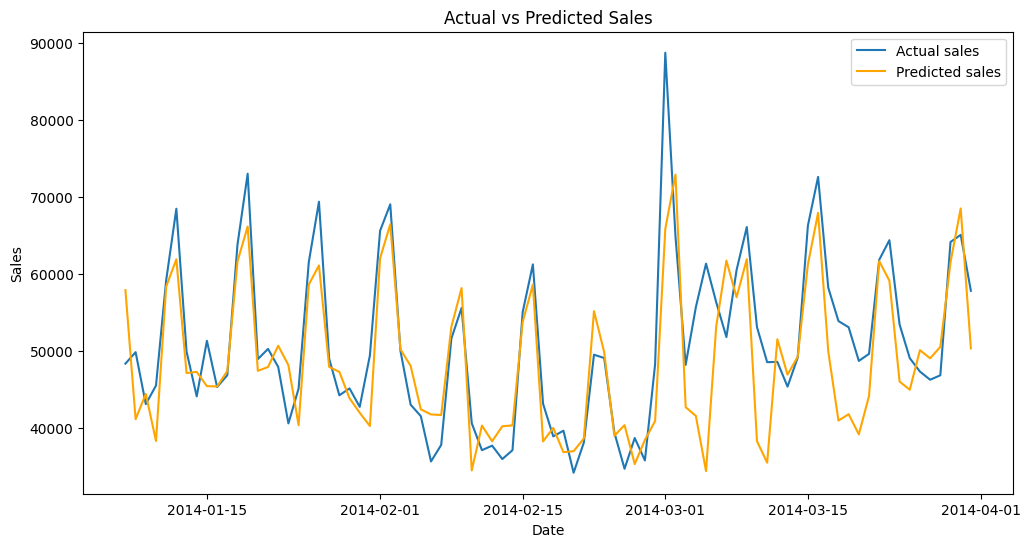

In [ ]:
# Plotting Actual vs Predicted Values
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test.values, label='Actual sales')
plt.plot(y_test.index, y_pred, label='Predicted sales', color='orange')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction.

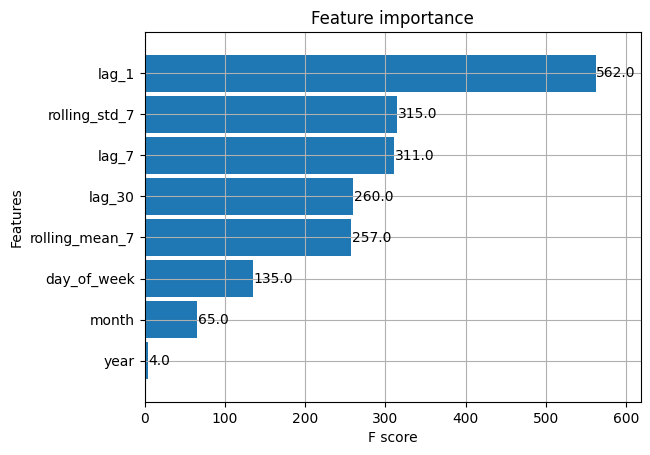

In [ ]:
# Feature Importance
plot_importance(xgboost_model, height=0.9);

In [ ]:
# Error metric of y_test and y_predict
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))

Mean Absolute Error: 4932.087512648809
Mean Squared Error: 45518414.12708482
Root Mean Squared Error: 6746.733589455332
R2 Score: 0.5932182161614925


In [ ]:
def mean_absolute_percentage_error(y_test, y_pred):
    """Calculates MAPE given y_test and y_pred"""
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

In [ ]:
percent_error=mean_absolute_percentage_error(y_test,y_pred)
print('Mean Absolute of Percent Error:', percent_error)

Mean Absolute of Percent Error: 9.490323218605772


It is about 10% error

Looking at the Worst and the Best Predicted Days

In [ ]:
Unitsale_test['error'] = y_test['sales_unit'] - y_pred['sales_unit']
Unitsale_test['abs_error'] = y_test['error'].apply(np.abs)

# when the error is calculated, let's group by year, month and the day
error_by_day = y_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]